# Exercise 3: Preparing Real-World Data for a Neural Network

Use the Spaceship Titanic dataset from Kaggle to practice data preprocessing for neural networks.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set random seed
np.random.seed(42)

## Load and Explore the Dataset

First, download the Spaceship Titanic dataset from Kaggle and place it in the data folder.

In [2]:
# Load the dataset
df = pd.read_csv('../data/train.csv')
print("Dataset loaded successfully!")

print(f"\nDataset shape: {df.shape}")
print(f"\nColumn names: {list(df.columns)}")
print(f"\nDataset objective: Predict if a passenger was transported to another dimension")

Dataset loaded successfully!

Dataset shape: (8693, 14)

Column names: ['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name', 'Transported']

Dataset objective: Predict if a passenger was transported to another dimension


In [3]:
# Explore the dataset
print("Dataset Info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())
print("\nTarget variable distribution:")
print(df['Transported'].value_counts())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
None

First 5 rows:
  PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B

In [5]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values[missing_values > 0])

# Visualize missing data
# plt.figure(figsize=(12, 6))
# sns.heatmap(df.isnull(), cbar=True, yticklabels=False, cmap='viridis')
# plt.title('Missing Data Pattern')
# plt.show()

Missing values per column:
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
dtype: int64


## Data Preprocessing for Neural Network

In [6]:
# Manual preprocessing functions
def handle_missing_numerical(series):
    """Fill missing values with median"""
    median_val = np.nanmedian(series)
    return np.where(np.isnan(series), median_val, series)

def handle_missing_categorical(series):
    """Fill missing values with mode"""
    # Get mode (most frequent value)
    unique, counts = np.unique(series[~pd.isna(series)], return_counts=True)
    mode_val = unique[np.argmax(counts)]
    return np.where(pd.isna(series), mode_val, series)

def one_hot_encode(series):
    """Manual one-hot encoding"""
    unique_vals = np.unique(series)
    encoded = np.zeros((len(series), len(unique_vals)))
    for i, val in enumerate(unique_vals):
        encoded[:, i] = (series == val).astype(int)
    return encoded, unique_vals

# Create a copy for preprocessing
df_processed = df.copy()

# Extract features from Cabin (Deck/Num/Side)
cabin_split = df_processed['Cabin'].str.split('/', expand=True)
df_processed['Deck'] = cabin_split[0]
df_processed['Cabin_Num'] = pd.to_numeric(cabin_split[1], errors='coerce')
df_processed['Side'] = cabin_split[2]

print("Missing values before preprocessing:")
print(df_processed.isnull().sum())

Missing values before preprocessing:
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
Deck            199
Cabin_Num       199
Side            199
dtype: int64


In [7]:
# Handle missing values manually
# Numerical features
numerical_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Cabin_Num']
for col in numerical_cols:
    df_processed[col] = handle_missing_numerical(df_processed[col].values)

# Categorical features
categorical_cols = ['HomePlanet', 'Destination', 'Deck', 'Side']
for col in categorical_cols:
    df_processed[col] = handle_missing_categorical(df_processed[col].values)

# Boolean features: convert to int and fill with 0
df_processed['CryoSleep'] = df_processed['CryoSleep'].fillna(False).astype(int)
df_processed['VIP'] = df_processed['VIP'].fillna(False).astype(int)

print("Missing values after preprocessing:")
print(df_processed.isnull().sum().sum())

Missing values after preprocessing:
399


/tmp/ipykernel_122878/3390914447.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_processed['CryoSleep'] = df_processed['CryoSleep'].fillna(False).astype(int)
/tmp/ipykernel_122878/3390914447.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_processed['VIP'] = df_processed['VIP'].fillna(False).astype(int)


In [8]:
# Manual encoding of categorical variables
encoded_features = []
feature_names = []

# Add numerical features
for col in numerical_cols:
    encoded_features.append(df_processed[col].values.reshape(-1, 1))
    feature_names.append(col)

# Add boolean features
encoded_features.append(df_processed['CryoSleep'].values.reshape(-1, 1))
encoded_features.append(df_processed['VIP'].values.reshape(-1, 1))
feature_names.extend(['CryoSleep', 'VIP'])

# One-hot encode categorical features manually
for col in categorical_cols:
    encoded, unique_vals = one_hot_encode(df_processed[col].values)
    encoded_features.append(encoded)
    feature_names.extend([f"{col}_{val}" for val in unique_vals])

# Combine all features
X_features = np.hstack(encoded_features)
y_target = df_processed['Transported'].astype(int).values

print(f"Encoded dataset shape: {X_features.shape}")
print(f"Number of features: {len(feature_names)}")
print(f"Target shape: {y_target.shape}")

Encoded dataset shape: (8693, 25)
Number of features: 25
Target shape: (8693,)


In [9]:
# Manual normalization for tanh activation
def normalize_for_tanh(X):
    """Normalize features for tanh activation (range roughly [-1, 1])"""
    X_normalized = np.zeros_like(X)
    for i in range(X.shape[1]):
        feature = X[:, i]
        mean_val = np.mean(feature)
        std_val = np.std(feature)
        # Standardize
        normalized = (feature - mean_val) / (std_val + 1e-8)  # Add small epsilon to avoid division by zero
        # Clip to [-2, 2] to work well with tanh
        X_normalized[:, i] = np.clip(normalized, -2, 2)
    return X_normalized

# Normalize features
X_normalized = normalize_for_tanh(X_features)

print(f"Normalized features shape: {X_normalized.shape}")
print(f"Feature range: [{X_normalized.min():.2f}, {X_normalized.max():.2f}]")
print(f"Feature mean: {X_normalized.mean():.4f}")
print(f"Feature std: {X_normalized.std():.4f}")

# Manual train-test split
def train_test_split_manual(X, y, test_size=0.2, random_state=42):
    """Manual train-test split with stratification"""
    np.random.seed(random_state)
    n_samples = len(X)
    n_test = int(n_samples * test_size)
    
    # Get indices for each class
    class_0_idx = np.where(y == 0)[0]
    class_1_idx = np.where(y == 1)[0]
    
    # Sample from each class proportionally
    n_test_0 = int(len(class_0_idx) * test_size)
    n_test_1 = int(len(class_1_idx) * test_size)
    
    test_idx_0 = np.random.choice(class_0_idx, n_test_0, replace=False)
    test_idx_1 = np.random.choice(class_1_idx, n_test_1, replace=False)
    
    test_idx = np.concatenate([test_idx_0, test_idx_1])
    train_idx = np.setdiff1d(np.arange(n_samples), test_idx)
    
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

# Split data
X_train, X_test, y_train, y_test = train_test_split_manual(X_normalized, y_target, test_size=0.2, random_state=42)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training class distribution: {np.bincount(y_train)}")
print(f"Test class distribution: {np.bincount(y_test)}")

Normalized features shape: (8693, 25)
Feature range: [-2.00, 2.00]
Feature mean: -0.0467
Feature std: 0.7903

Training set shape: (6955, 25)
Test set shape: (1738, 25)
Training class distribution: [3452 3503]
Test class distribution: [863 875]


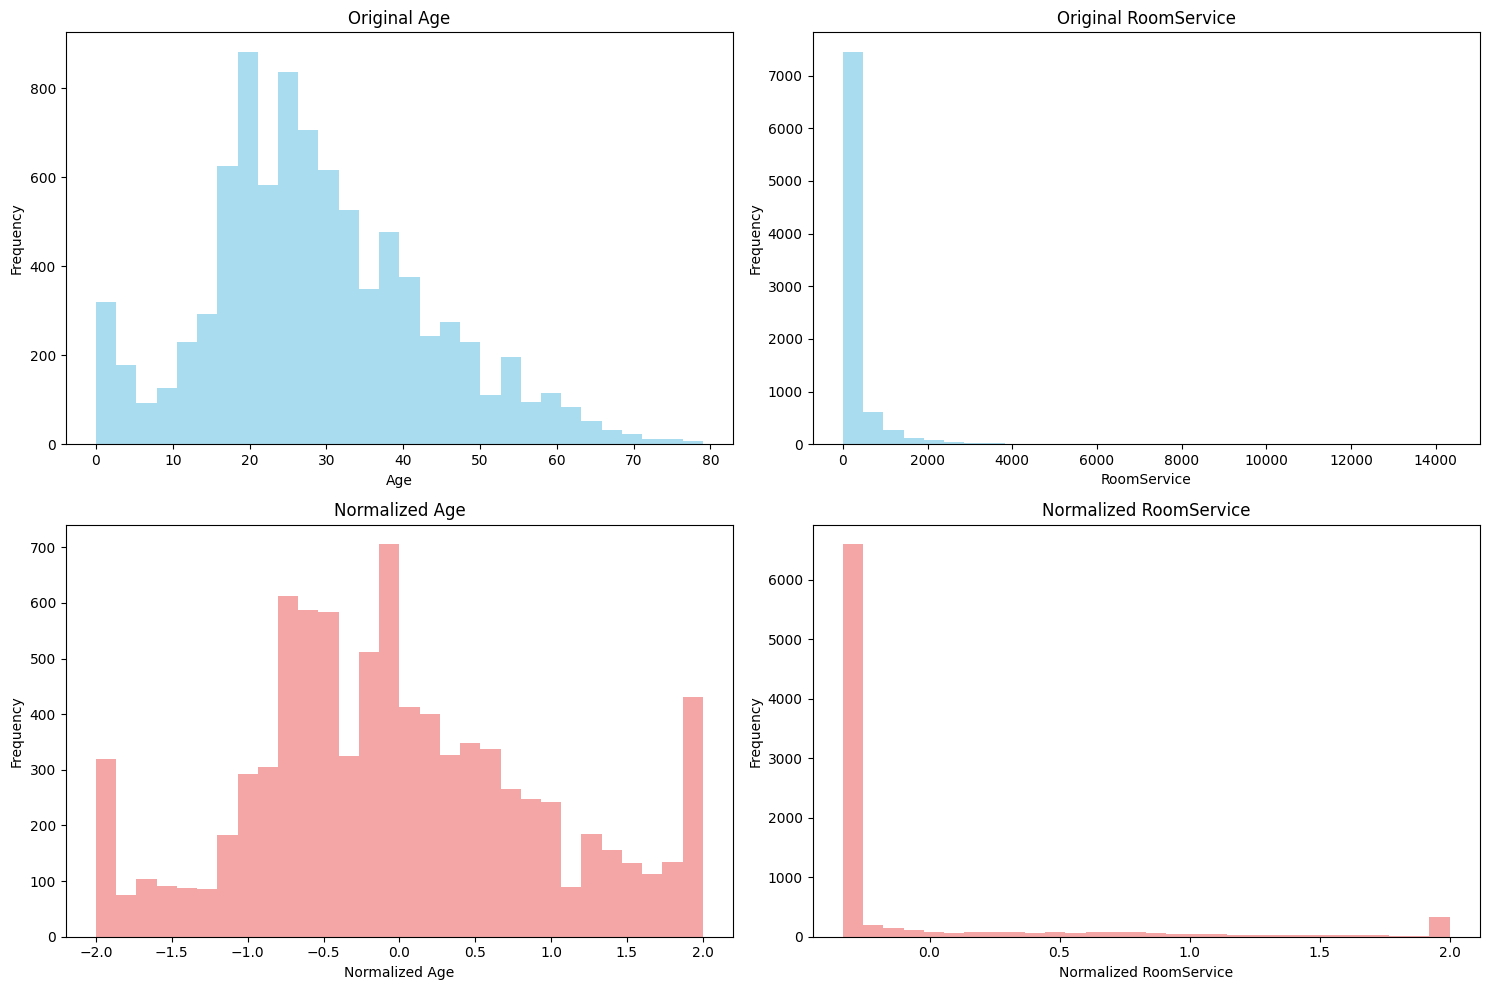

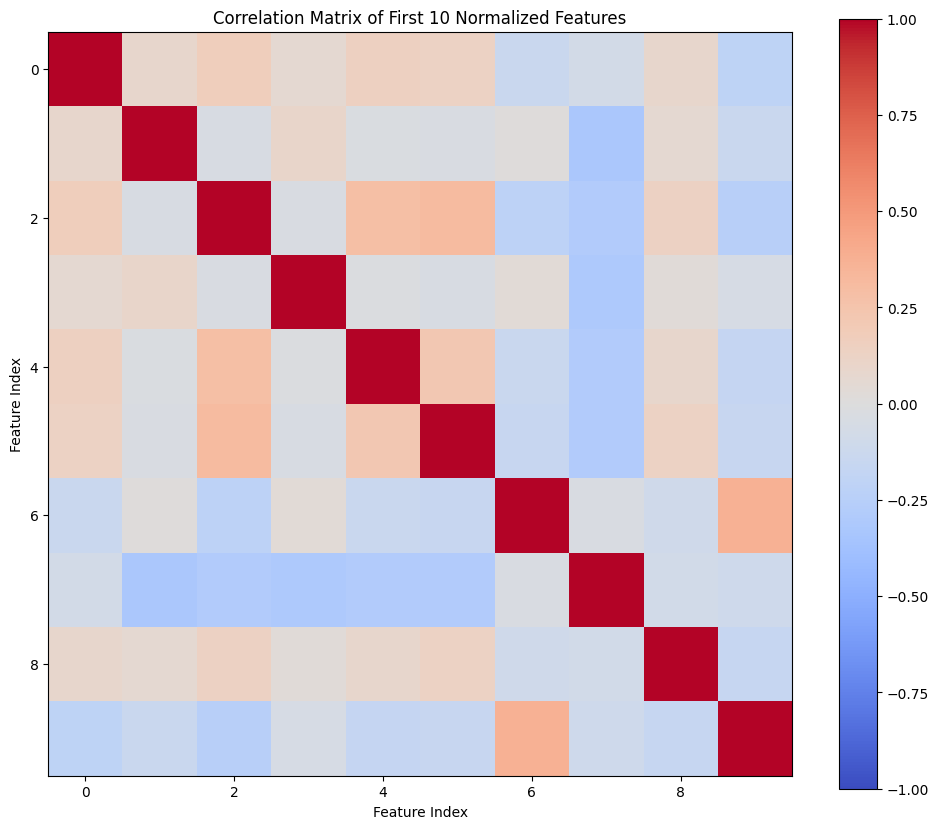

In [10]:
# Visualize data transformations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Show distribution of some original vs normalized features
features_to_plot = ['Age', 'RoomService']
feature_indices = [feature_names.index(feat) for feat in features_to_plot if feat in feature_names]

for i, (feat_name, feat_idx) in enumerate(zip(features_to_plot[:2], feature_indices[:2])):
    # Original distribution
    axes[0, i].hist(df_processed[feat_name], bins=30, alpha=0.7, color='skyblue')
    axes[0, i].set_title(f'Original {feat_name}')
    axes[0, i].set_xlabel(feat_name)
    axes[0, i].set_ylabel('Frequency')
    
    # Normalized distribution
    axes[1, i].hist(X_normalized[:, feat_idx], bins=30, alpha=0.7, color='lightcoral')
    axes[1, i].set_title(f'Normalized {feat_name}')
    axes[1, i].set_xlabel(f'Normalized {feat_name}')
    axes[1, i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Show correlation matrix of normalized features (first 10 features for readability)
plt.figure(figsize=(12, 10))
corr_matrix = np.corrcoef(X_normalized[:, :10].T)
plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.title('Correlation Matrix of First 10 Normalized Features')
plt.xlabel('Feature Index')
plt.ylabel('Feature Index')
plt.show()

## Summary

The dataset has been successfully preprocessed for neural network training:
- Missing values handled appropriately
- Categorical variables encoded
- Numerical features normalized for tanh activation
- Data split into training and test sets

The data is now ready for neural network training with tanh activation functions.